# Machine Learning for Single-Cell Biology
***

Winter Semester 2024/25<br />
Manfred Claassen, Matthias Bruhns, Jan Schleicher
<br />
***

## Assignment 2

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd
import scipy.optimize as opt
import seaborn as sns

from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from umap import UMAP

from tqdm.auto import tqdm

sns.set_style("ticks")
%matplotlib inline

np.random.seed(42)

In [2]:
DATA_PATH = "data/"

# Questions

- Should the data be scaled, or it is already preprocessed?
- Question 1D: "What are the differences between the two embeddings?" - should we discuss the differences between the algorithms or the results
- Question 2A: should we implement the quantile normalization by ourselves from scratch or is it okay to use the implementation in sklearn?

### Task 1 – Non-linear dimensionality reduction (70 points)

_Single-cell RNA sequencing data has high dimensionality due to the number of genes expressed in a typical cell. Non-linear embedding is often used to visualize the high- dimensional data in 2D. The various algorithms used for this task have different strategies to represent the relevant properties of the high dimensional data in 2D._

_**A.** Locally linear embedding (LLE) was an early technique that represents each data point as a linear combination of its neighbors. Explain the algorithm step by step and also implement standard LLE as described in the reference below. Use your LLE implementation to generate a 2D embedding of the data: expression_data_1.txt_

_Roweis, Sam T., and Lawrence K. Saul. “Nonlinear Dimensionality Reduction by Locally Linear Embedding.” Science, vol. 290, no. 5500, American Association for the Advancement of Science, 2000, pp. 2323–26, http://www.jstor.org/stable/3081722._

_Cell type identity for expression_data_1.txt have been provided in metadata_1.txt. Create a plot of the 2D embedding estimated above and annotate it with the cell type identity. (40 points)_


The LLE algorithm reconstructs each data point as a linear combination of its neighbors and embeds these relationships into a lower-dimensional space. It assumes that the data consists of $N$ vectors $\vec{X_i}$ of dimensionality $D$ (in our case, $N = $ number of cells, and $D = $ number of genes). Then, the LLE algorithm can be performed in 3 steps:

1. **Select $k$ neighbors for each point**: $\eta_{ij}$, $j \in {1, 2, \dots, k}$ and $i \in {1, 2, \dots, N}$.
    
    For this step, we used the k-nearest neighbors algorithm, implemented in `sklearn` with default parameters (except for the number of closest neighbours).

2. **Reconstruct the points with linear weights.**

    In this step, we compute the weights $W_{ij}$ that best linearly estimate each point $\vec{X_i}$ from its neighbours $\vec{\eta}_{i}$. For this, we solve the constrained least-squares equation:
    
    $$\epsilon (W) = \sum_i |\vec{X}_i - \sum_j W_{ij} \vec{X}_j|^2$$
    
    The weights must adhere to two constraints: (1) $W_{ij} = 0$ if $\vec{X}_j$ is not a neighbour of $\vec{X}_i$, and (2) the rows of the weight matrix $W$ must sum up to 1: $\sum_j W_j = 1$. These constraints can be taken into consideration by computing the weights (for a single point $\vec{X}_i$) as follows:

    (1) Evaluate the inner product between the neighbours $\vec{\eta}_j$ to compute the neighbourhood correlation matrix $C$ and its inverse $C^{-1}$:

    $$C = \vec{\eta}_j \vec{\eta}_j^T$$

    (2) Compute the Lagrange multiplier $\lambda$ that enforces the weights to sum to one:

    $$\lambda = \frac{\alpha}{\beta}$$

    $$\alpha = 1 - \sum_{jk} C_{jk}^{-1} (\vec{X}_i \cdot \vec{\eta}_j)$$

    $$\beta = \sum_{jk} C_{jk}^{-1}$$

    (3) Compute the reconstruction weights:

    $$w_j = \sum C_{jk}^{-1} (\vec{X}_i \cdot \vec{\eta}_j + \lambda)$$

    The weights $W_{ij}$ summarize the contribution of the $j$-th data point to the $i$-th reconstruction.

3. **Map the points to lower dimensional space coordinates.**

    Each high-dimensional observation $\vec{X}_i$ is mapped to a low-dimensional vector $\vec{Y}_i$ representing the coordinates in the low-dimensional space by minimizing the embedding cost function:

    $$\Phi(Y) = \sum_i |\vec{Y}_i - \sum_j W_{ij} \vec{Y}_j|^2$$

    In this cost function, the weights $W$ are fixed - we are now optimizing the coordinates $\vec{Y}_i$. The cost function is minimized by the following procedure:

    (1) Compute the symmetric matrix $M$:

    $$M = I - W - W^T + W^T W$$

    (2) Then, the embedding is the bottom $d + 1$ eigenvectors of this matrix (eigenvectors with the smallest eigenvalues, disregarding the first one).

In [3]:
# TODO: check if mathematical notation is correct and clear
# TODO: should the explanation be expanded?

In [4]:
# Load the data
expression_data_1 = np.loadtxt(os.path.join(DATA_PATH, "expression_data_1.txt"))
metadata_1 = pd.read_csv(os.path.join(DATA_PATH, "metadata_1.txt"), header = None, names = ["cell_type"])

In [5]:
def correlation(points):
    return points.dot(points.T) + np.eye(points.shape[0], points.shape[0]) * 1e-6


def lagrange(corr_inverse, x, x_neighbours):
    k = corr_inverse.shape[0]
    dots = np.zeros(k)
    for i in range(k):
        dots[i] = x.dot(x_neighbours[i, :])

    alpha = 1 - np.sum(corr_inverse * dots)
    beta = np.sum(corr_inverse)

    return alpha / beta


def weights(corr_inverse, x, x_neighbours, lagrange_lambda):
    k = corr_inverse.shape[0]
    dots = np.zeros(k)
    for i in range(k):
        dots[i] = x.dot(x_neighbours[i]) + lagrange_lambda

    weights = np.sum(corr_inverse * dots, axis = 1)
    assert np.isclose(np.sum(weights), 1, atol = 1e-5)

    return weights


def weights_for_sample(x, x_neighbours):
    # Calculate neighbourhood correlation matrix and its inverse
    corr = correlation(x_neighbours)
    corr_inverse = np.linalg.inv(corr)

    # Compute the lagrange multiplier (ensures weights sum up to one)
    lagrange_lambda = lagrange(corr_inverse, x, x_neighbours)

    # Calculate the weights
    return weights(corr_inverse, x, x_neighbours, lagrange_lambda)


def weight_matrix(expression, is_neighbour):
    # Weight matrix is initially zero and will be computed in a loop
    W = np.zeros((is_neighbour.shape[0], is_neighbour.shape[1]))

    for i, cell in enumerate(expression):
        neighbourhood = expression[is_neighbour[i, :], :]
        cell_weights = weights_for_sample(cell, neighbourhood)
        W[i, is_neighbour[i, :]] = cell_weights

    # Make sure all rows sum up to one
    assert np.all(np.isclose(np.sum(W, axis = 1), 1, atol = 1e-5))
    
    return W

In [6]:
def task_01_lle(data: np.array, dim_n: int, k = 5) -> np.array:
    """
    This function performs a locally-linear embedding.
    :param data: numpy array of shape (n_samples, n_features)
    :param dim_n: reduced dimensionality
    :param k: number of nearest neighbors
    :return: numpy array of shape (n_samples, dim_n)
    """

    ### Step 1: select neighbors

    # Assign neighbours to each data point
    # Use parameter k + 1 because the algorithm returns each point as
    # being a neighbor to itself
    knn = NearestNeighbors(n_neighbors = k + 1)
    neighbours = knn.fit(expression_data_1)

    is_neighbour = neighbours.kneighbors_graph(expression_data_1)
    is_neighbour = np.array(is_neighbour.toarray()) == 1
    # Remove each point being a neighbor to itself
    np.fill_diagonal(is_neighbour, False)

    # Make sure the neighbors are assigned correctly
    assert np.all(np.sum(is_neighbour, axis = 1) == k)

    ### Step 2: reconstruct with linear weights

    # Calculate the weight matrix
    W = weight_matrix(data, is_neighbour)

    ### Step 3: map to embedded coordinates

    # Calculate matrix M
    delta = np.eye(data.shape[0], data.shape[0])
    M = delta - W - W.T + W.T @ W

    # Find the smallest (dim_n + 1) eigenvalues - that's our embedding
    eigenvalues, eigenvectors = np.linalg.eig(M)
    sorted_indices = np.argsort(eigenvalues)
    eigenvectors = eigenvectors[:, sorted_indices]

    embedding = eigenvectors[:, 1:(dim_n + 1)]

    return embedding

In [7]:
# Task 1A
# Compute locally linear embedding for given data
task_01_solution = task_01_lle(data = expression_data_1, dim_n = 2)

In [147]:
def plot_embedding(categories, embedding, alpha = 1, ax = None, show_legend = False, legend_title = "Cell type"):
    if ax is None:
        _, ax = plt.subplots(nrows = 1, ncols = 1)
        show_legend = True

    color_palette = matplotlib.colormaps["Paired"]
    colors_map = [ color_palette(i) for i in range(len(categories.unique())) ]

    for i, category in enumerate(categories.unique()):
        point_idx = np.where(categories == category)

        ax.scatter(
            embedding[point_idx, 0], embedding[point_idx, 1],
            color = colors_map[i],
            alpha = alpha,
            s = 10,
            label = category
        )

    ax.set_xlabel("LLE dimension 1")
    ax.set_ylabel("LLE dimension 2")

    if show_legend:
        legend = plt.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
        legend.set_title(legend_title)
    
    if ax is None:
        plt.show()

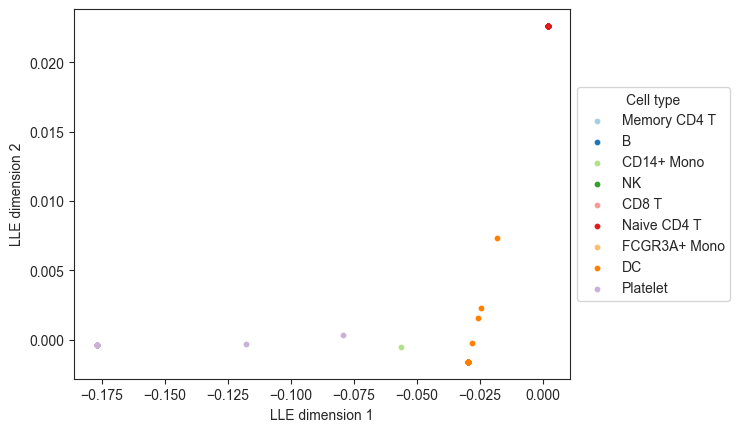

In [148]:
# Plot the embedding, annotated with cell type identity
plot_embedding(
    categories = metadata_1.cell_type.astype("category"),
    embedding = task_01_solution
)

In this case, LLE does not produce a very clear and useful result. The majority of the cells have very similar embeddings, so it is impossible to differentiate between them in the plot and see whether (and which) different cell types form any clusters.

_B. Next use the umap-learn package to generate a 2D UMAP embedding of the same data: expression_data_1.txt. Create a plot of the UMAP embedding annotated with the cell type identity. (5 points)_

In [10]:
# Task 1B
# Compute UMAP embedding of the given data and plot it
umap = UMAP()
embedding_umap = umap.fit_transform(expression_data_1)

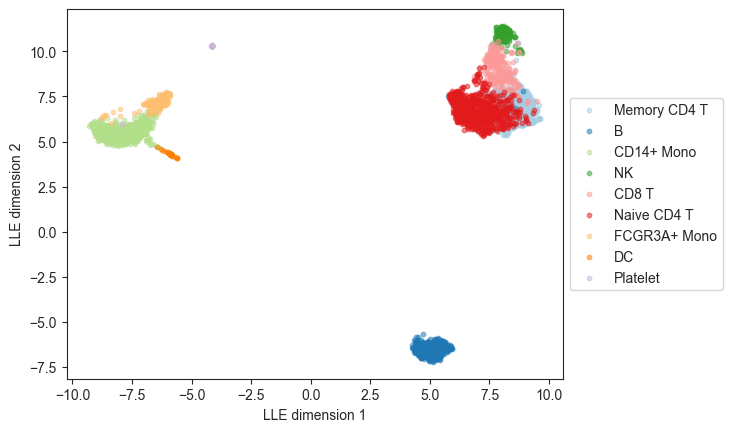

In [11]:
plot_embedding(
    categories = metadata_1.cell_type.astype("category"),
    embedding = embedding_umap,
    alpha = 0.5
)

The UMAP embedding visually provides more information than the LLE embedding. In the plot, we can see 3 clear clusters: (1) DC, CD14+ Mono, and FCGR3A+ Mono (with some Platelet cells), (2) Naive CD4 T, CD8 T, Memory CD4 T, and NK (with a few B cells), and (3) B cell cluster. This plot allows to see more clearly which cells cluster together, and, thus, have similar gene expression patterns.

_C. We will now investigate the role of the neighborhood parameter on the embeddings. For both LLE (use the sklearn implementation of LLE for this subtask) and UMAP generate embeddings for a range of neighborhood sizes from 5 to 100 in intervals of 5. Using each embedding and the provided cell type labels compute the Davies-Bouldin Index. Plot the dependence of the index on neighborhood size for both methods in a single plot. (10 points)_

In [104]:
# Task 1C
# Compute LLE and UMAP embeddings with different numbers of neighbors

neighborhood_sizes = np.arange(5, 100 + 5, 5)
labels = metadata_1.cell_type

davies_bouldin = []

for n_neighbors in neighborhood_sizes:
    print(f"Fitting for n_neighbors = {n_neighbors}")

    lle = LocallyLinearEmbedding(n_neighbors = n_neighbors)
    lle = lle.fit_transform(expression_data_1)

    umap = UMAP(n_neighbors = n_neighbors)
    umap = umap.fit_transform(expression_data_1)

    davies_bouldin.append(pd.DataFrame({
        "NeighborhoodSize": [n_neighbors],
        "LLE": [davies_bouldin_score(lle, labels)],
        "UMAP": [davies_bouldin_score(umap, labels)]
    }))

davies_bouldin = pd.concat(davies_bouldin)

Fitting for n_neighbors = 5
Fitting for n_neighbors = 10
Fitting for n_neighbors = 15
Fitting for n_neighbors = 20
Fitting for n_neighbors = 25
Fitting for n_neighbors = 30
Fitting for n_neighbors = 35
Fitting for n_neighbors = 40
Fitting for n_neighbors = 45
Fitting for n_neighbors = 50
Fitting for n_neighbors = 55
Fitting for n_neighbors = 60
Fitting for n_neighbors = 65
Fitting for n_neighbors = 70
Fitting for n_neighbors = 75
Fitting for n_neighbors = 80
Fitting for n_neighbors = 85
Fitting for n_neighbors = 90
Fitting for n_neighbors = 95
Fitting for n_neighbors = 100


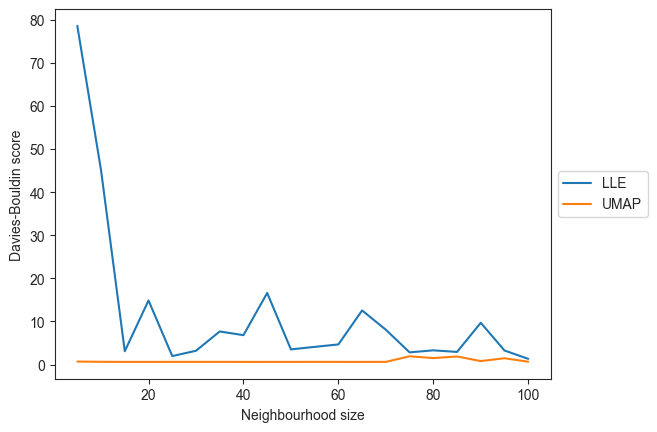

In [114]:
plt.plot(davies_bouldin.NeighborhoodSize, davies_bouldin.LLE, label = "LLE")
plt.plot(davies_bouldin.NeighborhoodSize, davies_bouldin.UMAP, label = "UMAP")
plt.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.xlabel("Neighbourhood size")
plt.ylabel("Davies-Bouldin score")
plt.show()

Davies-Bouldin index evaluates clustering quality by measuring the average similarity between clusters. The similarity is calculated as the ratio between the intra-cluster distances and the between-cluster distances. Lower score indicates better cluster separation as it means that the clusters are less dispersed and far from each other.

In the plot above we can see that the UMAP produces consistently good results with varying neighborhood sizes, while the LLE score tends to fluctuate. In general, UMAP performs better than LLE.

_D. Answer the following: (15 points)_

- What are the differences between the two embeddings?

    In the case of the LLE embedding, a lot of cells are mapped into very similar points in the lower-dimensional space. Thus, visualizing this data leads to an unclear result with multiple cells (and multiple types of cells) being visualized in the exact same point and different clusters are impossible to tell apart. In the UMAP embedding, no cells are mapped to the exact same low-dimensional point and thus the UMAP embedding is able to capture the cluster-like structure of the data.

- Which embedding is better suited to visualize cell populations and why?

    UMAP is better suited to visualize cell populations. In the low-dimensional plot of the UMAP result we can clearly see different types of cells and their clusters (which cannot be said about the LLE result). UMAP algorithm is able to maintain both the local and the global information of the data points. This results in more clear visualizations and better clustering quality (based on the Davies-Bouldin index).

- Based on your plots, what do you think are the conceptual differences between the two embedding techniques?

    The LLE algorithm does not take into consideration the global relationships between the points. In the single cell data, the global relationships are critical as they can represent different developmental trajectories. Moreover, it assumes that the data lie on a smooth multidimensional manifold which is not true for the single cell data (the different cell types may not form a single continuous manifold).

    UMAP, on the other hand, captures the global structure within the single cell data.

### Task 2 – Batch effects in scRNA seq data (30 points)

_Differences between single-cell RNA sequencing datasets generated independently can be ascribed to biological and non-biological sources of variation. Typically, the non-biological sources of variation can lead to incorrect conclusions, and therefore batch effect correction is an important processing step in the analysis of multiple single-cell RNA sequencing datasets._

_A. Explain the algorithm step by step and implement quantile normalization as a batch correction strategy for single-cell RNA sequencing data. Use your implementation to correct batch effects present in the dataset: expression_data_2.txt. (20 points)_

In [115]:
# Load data
expression_data_2 = pd.read_csv(os.path.join(DATA_PATH, "expression_data_2.txt"), sep="\t", index_col=0)
metadata_2 = pd.read_csv(os.path.join(DATA_PATH, "metadata_2.txt"), sep="\t", index_col=0)

In [ ]:
# 

In [121]:
def task_02_quantile_normalization(data: pd.DataFrame, meta_data: pd.DataFrame, target: str) -> pd.DataFrame:
    """
    This function performs quantile normalization as batch correction.
    :param data: pandas DataFrame of shape (n_cells, n_genes)
    :param meta_data: pandas DataFrame containing the target variable to correct for
    :param target: target variable in meta_data
    :return: pandas DataFrame with quantile normalized data
    """
    corrected_data = data.copy()

    #########################
    # INSERT YOUR CODE HERE #
    #########################

    return corrected_data

In [122]:
# Task 2
task_02_solution = task_02_quantile_normalization(data=expression_data_2, meta_data=metadata_2, target="celltype")

_B. Batch and celltype labels for each cell are provided in metadata_2.txt. Create two plots visualizing pre-corrected and batch-corrected data using UMAP embedding. An- notate with the provided batch labels. Is the batch correct satisfactory? Explain your assessment for either outcome. (10 points)_

In [ ]:
# Compute UMAP and plot uncorrected and corrected data with batch and celltype annotation

# Setting a random state for each UMAP instance to ensure consistent results
embedding_umap_before = UMAP(random_state = 42, n_jobs = 1).fit_transform(expression_data_2)
embedding_umap_after = UMAP(random_state = 42, n_jobs = 1).fit_transform(task_02_solution)

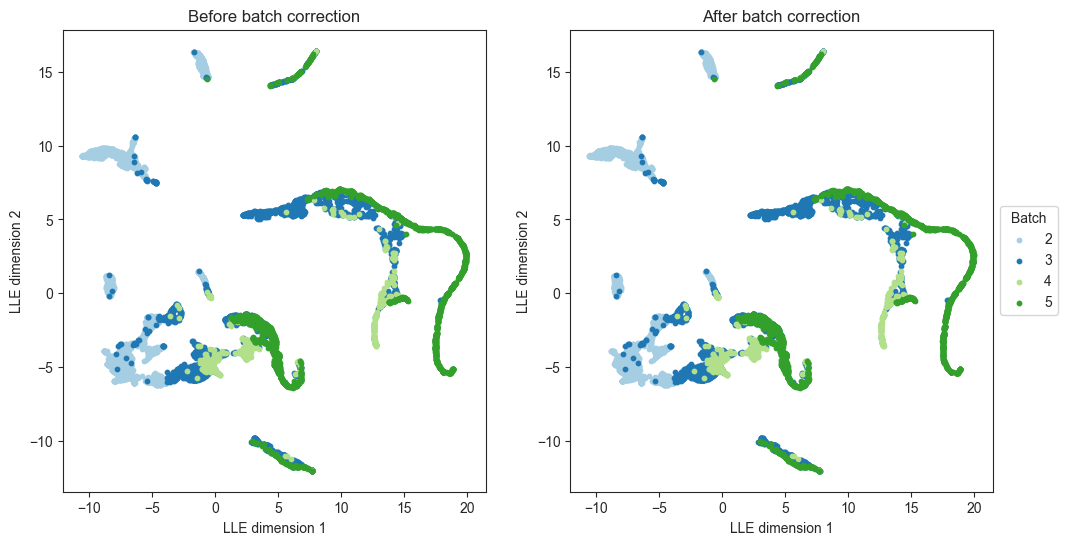

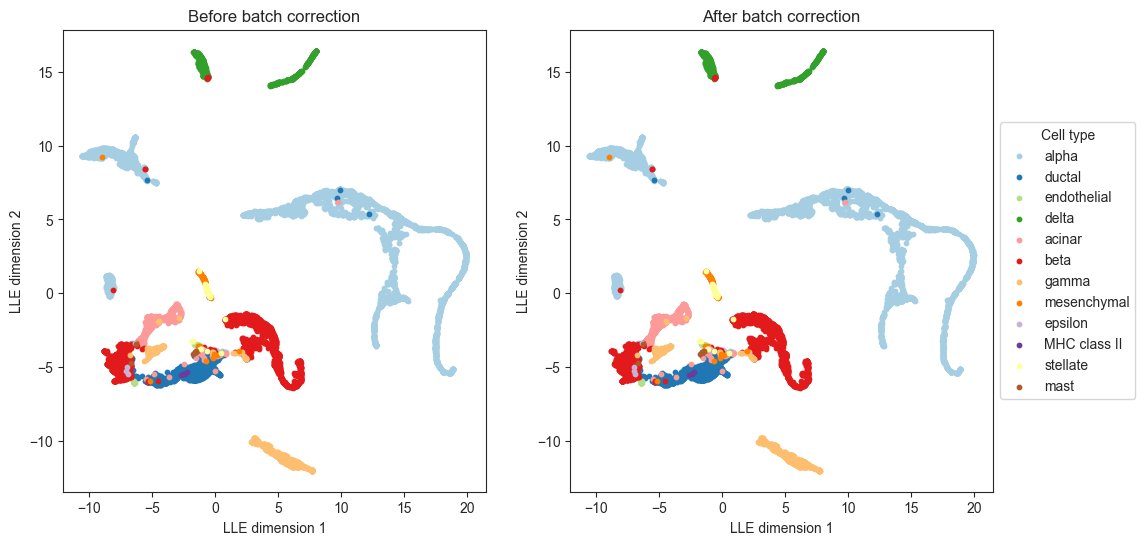

In [160]:
#
# Plotting the data before and after batch correction, annotated with
# batch labels
#

_, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

plot_embedding(
    categories = metadata_2.batch.astype("category"),
    embedding = embedding_umap_before,
    ax = axs[0]
)

axs[0].set_title("Before batch correction")

plot_embedding(
    categories = metadata_2.batch.astype("category"),
    embedding = embedding_umap_after,
    ax = axs[1],
    show_legend = True,
    legend_title = "Batch"
)

axs[1].set_title("After batch correction")

plt.show()

#
# Plotting the data before and after batch correction, annotated with
# cell type labels
#

_, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

plot_embedding(
    categories = metadata_2.celltype.astype("category"),
    embedding = embedding_umap_before,
    ax = axs[0]
)

axs[0].set_title("Before batch correction")

plot_embedding(
    categories = metadata_2.celltype.astype("category"),
    embedding = embedding_umap_after,
    ax = axs[1],
    show_legend = True,
    legend_title = "Cell type"
)

axs[1].set_title("After batch correction")

plt.show()